In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import cv2,os
import numpy as np
from sklearn.model_selection import train_test_split

FILE_LOCATION = ""
FILE_FORMAT = "SampleData/{}/"
FILE_FORMATE = "SampleData/160x160/{}/"
def convert_to_min(disease):
    if type(disease)!=dict:
        print("Need disease in the dictionay format")
        return
    if not os.path.isdir(FILE_LOCATION+"SampleData/160x160/"):
        os.mkdir(FILE_LOCATION+"SampleData/160x160/")
    for d in disease.keys():
        new_location = FILE_LOCATION+FILE_FORMATE.format(d)
        if not os.path.isdir(new_location):
            os.mkdir(new_location)
        for file in os.listdir(FILE_LOCATION+FILE_FORMATE.format(d)):
            if file[-4:] not in (".xml",".txt"):
                try:
                    name = FILE_LOCATION+FILE_FORMATE.format(d)+"{}".format(file)
                    oriimage = cv2.imread(name)
                    newimage = cv2.resize(oriimage,(160,160))
                    cv2.imwrite(new_location+"/{}".format(file),newimage)
                except:
                    print("Failed on the file "+name)

def disease_test_train(disease):
    if type(disease)!=dict:
        print("Need disease in the dictionay format")
        return [],[],[],[]
    
    images, labels = [], []
    for d in disease.keys(): # Look for each disease in the directory...
        for file in os.listdir(FILE_LOCATION+FILE_FORMATE.format(d)): # Read all the files in directory
            if file[-4:] not in {".xml",".txt"}: # Read only the images.. 
                name = FILE_LOCATION+FILE_FORMATE.format(d)+"{}".format(file) # The file name of the image.
                oriimage = cv2.imread(name, cv2.IMREAD_UNCHANGED) # Read the image in RGB Format
                oriimage = cv2.cvtColor(oriimage,cv2.COLOR_BGR2RGB)
                images.append(oriimage) 
                labels.append(disease[d])
    images = np.asarray(images) # Converting normal list to numpy array
    labels = np.asarray(labels) # Converting normal list to numpy array
    return train_test_split(images, labels, test_size=0.2)# Split the data in 80:20 

disease = {"Allergic Eczema":0, "Cellulitis":1, "Chickenpox":2}
convert_to_min(disease)
train_images, test_images, train_labels, test_labels = disease_test_train(disease)
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

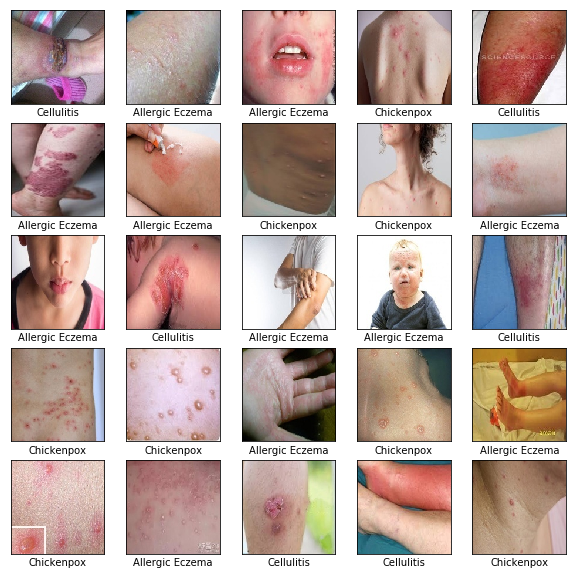

In [4]:
# ploting few images befor applying any changes.... 
class_names = ['Allergic Eczema', 'Cellulitis','Chickenpox']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [5]:
model = models.Sequential()
model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(320, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(320, (3, 3), activation='relu'))
model.summary()
model.add(layers.Flatten())
model.add(layers.Dense(320, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 158, 158, 160)     4480      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 160)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 77, 77, 320)       461120    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 320)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 320)       921920    
Total params: 1,387,520
Trainable params: 1,387,520
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


Confusion Matrix:
 [[61  0  0]
 [25  0  0]
 [26  0  0]]
Precision:  0.18154761904761904
Accuracy:  0.5446428571428571


/home/lapi/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


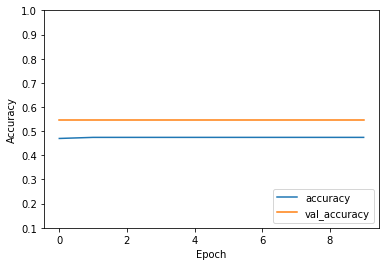

In [7]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

from sklearn.metrics import confusion_matrix
y_pred = list(map(np.argmax, model.predict(test_images)))
y_true = test_labels
print("Confusion Matrix:\n", confusion_matrix(y_true,y_pred))

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
print("Precision: ", precision_score(y_true, y_pred,average='macro'))
print("Accuracy: ", accuracy_score(y_true, y_pred))


Following code was written to go through the XML and enlist the filelocation, name, image size.. 
To know the minimum size of the files... 

In [ ]:
import os, csv
import xml.dom.minidom
disease = ["Allergic Eczema", "Cellulitis","Chickenpox"]
with open("file.csv","w") as ff:
    ff = csv.writer(ff,delimiter=",",quoting=csv.QUOTE_MINIMAL)
    for d in disease:
        for file in os.listdir("SampleData/"+d+"/"):
            if file[-4:] == ".xml":
                name = "SampleData/{}/{}".format(d,file)
                doc = xml.dom.minidom.parse(name)
                dis = doc.getElementsByTagName('folder')[0].firstChild.data
                file = doc.getElementsByTagName('filename')[0].firstChild.data

                size = doc.getElementsByTagName("size")

                width = size[0].getElementsByTagName('width')[0].firstChild.data
                height = size[0].getElementsByTagName('height')[0].firstChild.data
                depth = size[0].getElementsByTagName('depth')[0].firstChild.data
                ff.writerow([name, d, width, height, depth])

In the following code we are looking to use another popular and lightweight*** neural network called MobileNet
It's advantage is that it's lightweighted and use much more layers in a compact way and gives access to 
modify the layer as needed. 

In [8]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet ### Important.. 
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224)) # For this example we are using image of 224*224(In CNN with 3 layers, I saw the slowdown of the system, where as here it's not a problem.)
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

Using TensorFlow backend.


In [9]:
mobile = keras.applications.mobilenet.MobileNet()
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

/home/lapi/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [10]:
model=Model(inputs=base_model.input,outputs=preds)

In [11]:
for i,layer in enumerate(model.layers):
    print(i,layer.name)

0 input_2
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [12]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [13]:
import os,shutil
from sklearn.model_selection import train_test_split
FILE_LOCATION = ""
FILE_FORMAT = "SampleData/{}/"
disease = {"Allergic Eczema":0, "Cellulitis":1, "Chickenpox":2}
os.mkdir(FILE_LOCATION+"SampleData/train/")
os.mkdir(FILE_LOCATION+"SampleData/test/")

for d in disease.keys(): # Look for each disease in the directory...
    images = []
    labels  = []
    os.mkdir(FILE_LOCATION+"SampleData/train/{}/".format(d))
    os.mkdir(FILE_LOCATION+"SampleData/test/{}/".format(d))
    for file in os.listdir(FILE_LOCATION+FILE_FORMAT.format(d)): # Read all the files in directory
        if file[-4:] not in {".xml",".txt"}: # Read only the images.. 
            name = FILE_LOCATION+FILE_FORMAT.format(d)+"{}".format(file) # The file name of the image.
            images.append(name) 
            labels.append(disease[d])

    images = np.asarray(images) # Converting normal list to numpy array
    labels = np.asarray(labels) # Converting normal list to numpy array
    train_images, test_images, _, _ = train_test_split(images, labels, test_size=0.2)# Split the data in 80:20 
    for dest in train_images:
        shutil.copy2(dest,FILE_LOCATION+"SampleData/train/{}/".format(d))
    for dest in test_images:
        shutil.copy2(dest,FILE_LOCATION+"SampleData/test/{}/".format(d))

In [14]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
train_generator=train_datagen.flow_from_directory(FILE_LOCATION+"SampleData/train",
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 446 images belonging to 3 classes.


In [15]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
13/13 [==============================] - 102s 8s/step - loss: 1.4180 - acc: 0.5721
Epoch 2/10
13/13 [==============================] - 97s 7s/step - loss: 0.5826 - acc: 0.8037
Epoch 3/10
13/13 [==============================] - 98s 8s/step - loss: 0.3368 - acc: 0.8814
Epoch 4/10
13/13 [==============================] - 98s 8s/step - loss: 0.2448 - acc: 0.9420
Epoch 5/10
13/13 [==============================] - 97s 7s/step - loss: 0.1318 - acc: 0.9591
Epoch 6/10
13/13 [==============================] - 97s 7s/step - loss: 0.2960 - acc: 0.8939
Epoch 7/10
13/13 [==============================] - 97s 7s/step - loss: 0.1779 - acc: 0.9444
Epoch 8/10
13/13 [==============================] - 97s 7s/step - loss: 0.0691 - acc: 0.9826
Epoch 9/10
13/13 [==============================] - 97s 7s/step - loss: 0.0387 - acc: 0.9856
Epoch 10/10
13/13 [==============================] - 97s 7s/step - loss: 0.1258 - acc: 0.9659


In [16]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

y_true, y_pred = [],[]
disease = {"Allergic Eczema":0, "Cellulitis":1, "Chickenpox":2}
for d in disease.keys():
    for file in os.listdir(FILE_LOCATION+"SampleData/train/{}/".format(d)):
        img_path = FILE_LOCATION+"SampleData/train/{}/".format(d)+"{}".format(file)
        new_image = load_image(img_path)
        pred = model.predict(new_image)
        y_pred.append(np.argmax(pred))
        y_true.append(disease[d])

from sklearn.metrics import confusion_matrix
print("Confusion Matrix:\n", confusion_matrix(y_true,y_pred))

# Precision and Recall

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
print("Precision: ", precision_score(y_true, y_pred,average='micro'))
print("Accuracy: ", accuracy_score(y_true, y_pred))

Confusion Matrix:
 [[201   3  14]
 [ 48  57  11]
 [ 18   1  93]]
Precision:  0.7869955156950673
Accuracy:  0.7869955156950673
